# Quake Template Matching (QTM) Catalog [1]

Using data collected by the SCSN, [1] generated a denser catalog by reanalyzing the same waveform data with a template matching procedure that looks for cross-correlations with the wavetrains of previously detected events. The catalog contains 1.81 million earthquakes complete down to Mw 0.3. 

## Downloading the dataset

We begin by importing the neccessary dependencies

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import shutil
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
from plot_utils import download_txt_file, maxc, azimuthal_equidistant_projection
from scipy.stats import linregress

# Custom Colormap
colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]

The data can be downloaded from https://service.scedc.caltech.edu/ftp/QTMcatalog/qtm_final_12dev.hypo . 

In [2]:
# Define the URL and the local filename
url = "https://service.scedc.caltech.edu/ftp/QTMcatalog/qtm_final_12dev.hypo"
path_to_destination = "./raw/"

# Download and extract the file
download_txt_file(url, path_to_destination)

CSV file created successfully.


In [3]:
raw_catalog = pd.read_csv("raw/events.csv")
raw_catalog['time'] = pd.to_datetime(raw_catalog['time'])
raw_catalog = raw_catalog.sort_values(by='time')
raw_catalog = raw_catalog[["time", "longitude", "latitude","magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)
print('the raw catalog has', len(raw_catalog),'events')

the raw catalog has 898597 events


## Visualising the Catalog

Let's plot events in the raw catalog over time along with an estimate of the completeness using Maximum Curvature [2]. We can see that the completeness of the catalog is relatively stable across the time period of the catalog, however including some increases following larger earthquakes and aftershock sequences.

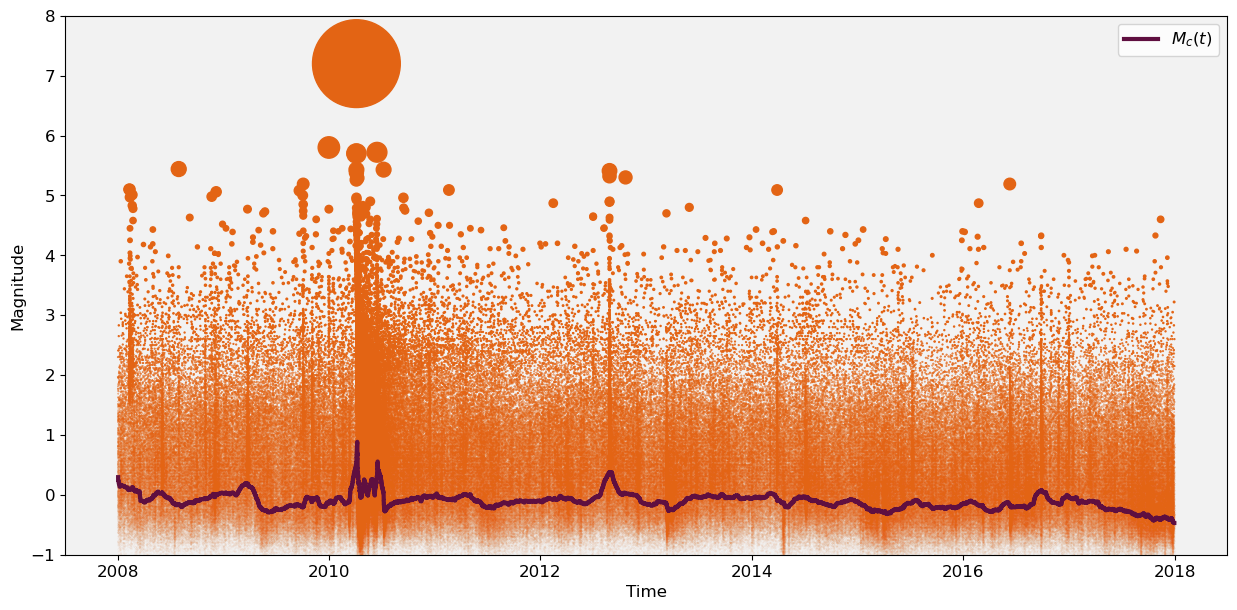

In [4]:
%matplotlib inline
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(raw_catalog['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = raw_catalog['time']
comp_M = raw_catalog['magnitude']

for i in range(nwindows):
    
    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (7.5**raw_catalog['magnitude'])*0.002
plt.scatter(raw_catalog['time'],raw_catalog['magnitude'],s=z,color =colors[3])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.ylim([-1,8])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

For this catalog we chose to target two focus areas following [3]. The first contains the San Jacinto Fault-Zone Region,. The second contains the Salton Sea, a remnant of ancient Lake Cahuilla that periodically filled and desiccated over the past millennium [4].

## Truncating the Catalog

Let's first create two subcatalogs based on our two focus areas: San Jacinto and Salton Sea.

In [5]:
SanJac_polygon_coords = np.load('SanJac_shape.npy')
## filter events within polygon
SanJac_poly = Polygon(SanJac_polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(
        raw_catalog.latitude, raw_catalog.longitude),)

SanJac_catalog = gdf[gdf.intersects(SanJac_poly)].copy()
SanJac_catalog.drop("geometry", axis=1, inplace=True)


SaltonSea_polygon_coords = np.load('SaltonSea_shape.npy')
## filter events within polygon
SaltonSea_poly = Polygon(SaltonSea_polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(
        raw_catalog.latitude, raw_catalog.longitude),)

SaltonSea_catalog = gdf[gdf.intersects(SaltonSea_poly)].copy()
SaltonSea_catalog.drop("geometry", axis=1, inplace=True)

Let's now visualise the coordinates of the events in the catalog

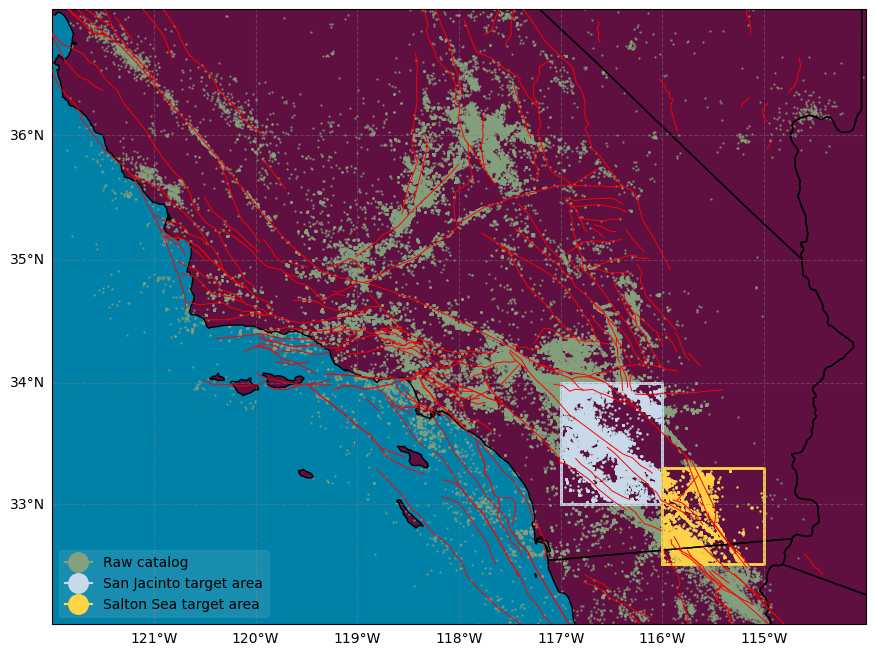

In [6]:
# Read the GEM fault data
gdf = gpd.read_file('/home/ss15859/Downloads/gem_active_faults.gpkg')
faults = gdf.geometry

# Filter the GeoDataFrame to include only geometries within the specified extent
max_lat, min_lat, max_lon, min_lon = 37, 32, -114, -122
filtered_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Extract the geometry of the faults within the specified extent
faults_within_extent = filtered_gdf.geometry


# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-122, -114, 32, 37], crs=ccrs.PlateCarree())

# Add colored land and ocean
ax.add_feature(cfeature.LAND, facecolor="#5F0F40")
ax.add_feature(cfeature.OCEAN, facecolor="#0081A7")
ax.add_feature(cfeature.STATES, edgecolor='black')


# Plot the faults
for geom in faults_within_extent:
    ax.plot(geom.xy[0], geom.xy[1], color='red', transform=ccrs.PlateCarree(),zorder=10,linewidth=0.7)


# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)



SanJac_plot_polygon_coords = np.append(SanJac_polygon_coords, [SanJac_polygon_coords[0]], axis=0)
ax.plot(SanJac_plot_polygon_coords[:, 1], SanJac_plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[1], lw=2)


SaltonSea_plot_polygon_coords = np.append(SaltonSea_polygon_coords, [SaltonSea_polygon_coords[0]], axis=0)
ax.plot(SaltonSea_plot_polygon_coords[:, 1], SaltonSea_plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[7], lw=2)


# Plot events
ax.scatter(raw_catalog['longitude'], raw_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[2], alpha=0.8,label='Raw catalog')
ax.scatter(SanJac_catalog['longitude'], SanJac_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[1], alpha=0.8,label='San Jacinto target area')
ax.scatter(SaltonSea_catalog['longitude'], SaltonSea_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[7], alpha=0.8,label='Salton Sea target area')
legend_marker_size=14
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=colors[2], label='Raw catalog',
                                markerfacecolor=colors[2], markersize=legend_marker_size),
                   plt.Line2D([0], [0], marker='o', color=colors[1], label='San Jacinto target area',
                                markerfacecolor=colors[1], markersize=legend_marker_size),
                   plt.Line2D([0], [0], marker='o', color=colors[7], label='Salton Sea target area',
                                markerfacecolor=colors[7], markersize=legend_marker_size)],facecolor='white', framealpha=0.1)
plt.show()

Since the catalogs completeness is consistent across the time period, we don't need to truncate the catalog in time.

In [7]:
# filter events within timewindow
auxiliary_start = '2008-01-01 00:00:00'
test_nll_end = '2018-01-01 00:00:00'
len_SanJac = len(SanJac_catalog)
SanJac_catalog = SanJac_catalog[SanJac_catalog['time']>=auxiliary_start]
SanJac_catalog = SanJac_catalog[SanJac_catalog['time']<test_nll_end]
len_SanJac_trunc_t = len(SanJac_catalog)
print('Removed',len_SanJac-len_SanJac_trunc_t, 'events outside timewindow')

Removed 0 events outside timewindow


In [8]:
# filter events within timewindow
auxiliary_start = '2008-01-01 00:00:00'
test_nll_end = '2018-01-01 00:00:00'
len_SaltonSea = len(SaltonSea_catalog)
SaltonSea_catalog = SaltonSea_catalog[SaltonSea_catalog['time']>=auxiliary_start]
SaltonSea_catalog = SaltonSea_catalog[SaltonSea_catalog['time']<test_nll_end]
len_SaltonSea_trunc_t = len(SaltonSea_catalog)
print('Removed',len_SaltonSea-len_SaltonSea_trunc_t, 'events outside timewindow')

Removed 0 events outside timewindow


Let's now look at choosing a magnitude threshold by looking at where the magnitude-frequency histogram deviates from the Gutenberg-Richter law.

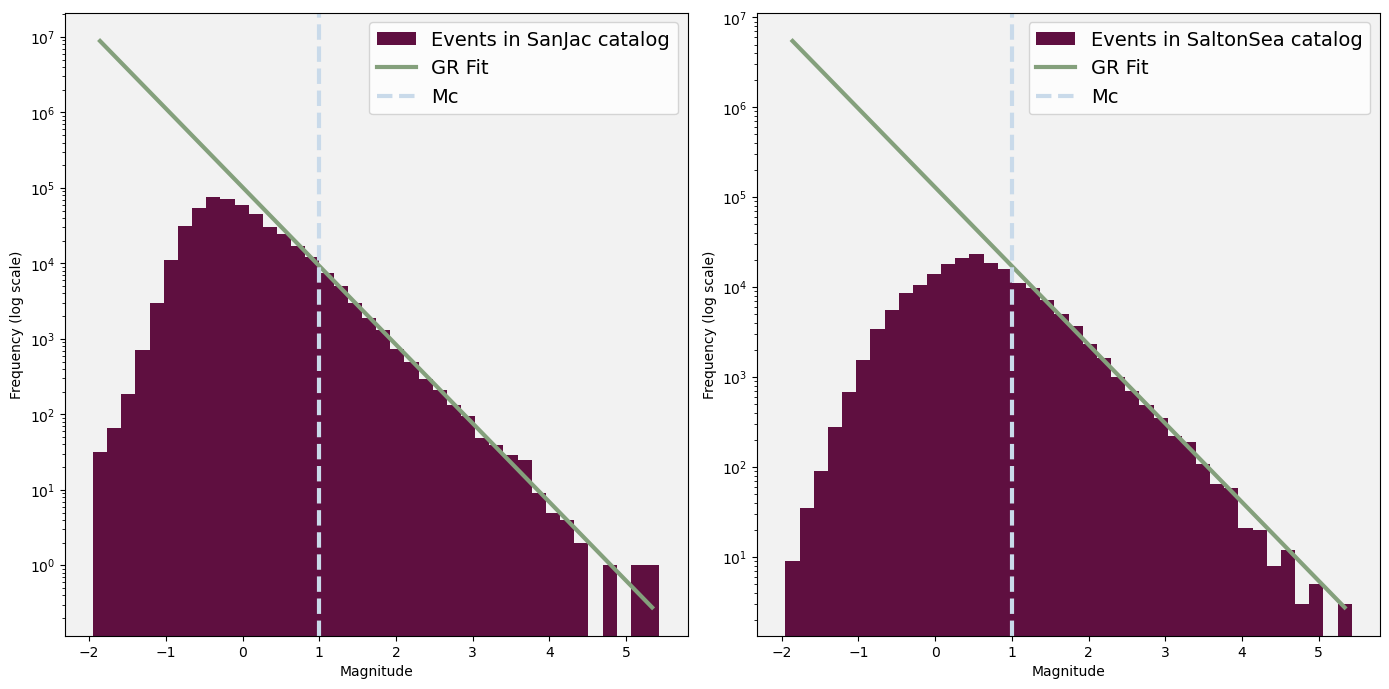

In [9]:
# Plotting parameters
bins = 40
linew = 3
background_color = (0.95, 0.95, 0.95)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First plot (SanJac catalog)
ax1.set_facecolor(background_color)
hist, bins = np.histogram(SanJac_catalog['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

ax1.hist(SanJac_catalog['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events in SanJac catalog')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency (log scale)')

# Fit a GR line to the log-transformed histogram data
mask = (bin_centers >= 1) & (bin_centers <= 4.5)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers[mask], log_hist[mask])
ax1.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-', color=colors[2], label='GR Fit', linewidth=linew)
ax1.axvline(x=1, color=colors[1], linestyle='--', label='Mc', linewidth=linew)

ax1.legend(fontsize=14)

# Second plot (SaltonSea catalog)
ax2.set_facecolor(background_color)
hist, bins = np.histogram(SaltonSea_catalog['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

ax2.hist(SaltonSea_catalog['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events in SaltonSea catalog')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Frequency (log scale)')

# Fit a GR line to the log-transformed histogram data
mask = (bin_centers >= 1) & (bin_centers <= 4)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers[mask], log_hist[mask])
ax2.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-', color=colors[2], label='GR Fit', linewidth=linew)
ax2.axvline(x=1, color=colors[1], linestyle='--', label='Mc', linewidth=linew)

ax2.legend(fontsize=14)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

We agree with [3], and set Mc at 1.0.

Let's truncate events above this threshold.

In [10]:
# filter events above magnitude threshold
Mcut = 1.0
SanJac_catalog = SanJac_catalog[SanJac_catalog['magnitude']>=Mcut]
SaltonSea_catalog = SaltonSea_catalog[SaltonSea_catalog['magnitude']>=Mcut]
print('Removed',len_SanJac_trunc_t-len(SanJac_catalog), 'events below Mcut from SanJac catalog')
print('Removed',len_SaltonSea_trunc_t-len(SaltonSea_catalog), 'events below Mcut from SaltonSea catalog')

Removed 436508 events below Mcut from SanJac catalog
Removed 140282 events below Mcut from SaltonSea catalog


## Avoiding duplicated Locations

### SanJac

In [11]:
# # ============================Jittering Location of events=============================================
# set the random seed 
np.random.seed(42)

df_modified = SanJac_catalog.copy()

# set the jettering range 
spatial_jitter_range = 0.005 # = 0.5km
time_jitter_range = 0.1/86400  

# deal with spatial duplication 
while True:
    duplicates = df_modified[df_modified.duplicated(subset=['longitude', 'latitude'], keep=False)]

    if duplicates.empty:
        print("no duplicate points found, finished!")
        break
    
    for idx in duplicates.index:
        df_modified.loc[idx, 'longitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)
        df_modified.loc[idx, 'latitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)

    print(f"there are {len(duplicates)} duplicate points, continue adding noise...")



while True:
    duplicates = df_modified[df_modified.duplicated(subset=['time'], keep=False)]

    if duplicates.empty:
        print("no duplicate time found, finished!")
        break
    
    for idx in duplicates.index:
        time_jitter = np.random.uniform(-time_jitter_range/2, time_jitter_range/2)
        df_modified.loc[idx, 'time'] += pd.to_timedelta(time_jitter, unit='s')

    print(f"there are {len(duplicates)} duplicate time, continue adding noise...")

df_modified.sort_values(by='time', inplace=True)

SanJac_catalog = df_modified.copy()

there are 1935 duplicate points, continue adding noise...
no duplicate points found, finished!
no duplicate time found, finished!


### SaltonSea

In [12]:
# # ============================Jittering Location of events=============================================
# set the random seed 
np.random.seed(42)

df_modified = SaltonSea_catalog.copy()

# set the jettering range 
spatial_jitter_range = 0.005 # = 0.5km
time_jitter_range = 0.1/86400  

# deal with spatial duplication 
while True:
    duplicates = df_modified[df_modified.duplicated(subset=['longitude', 'latitude'], keep=False)]

    if duplicates.empty:
        print("no duplicate points found, finished!")
        break
    
    for idx in duplicates.index:
        df_modified.loc[idx, 'longitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)
        df_modified.loc[idx, 'latitude'] += np.random.uniform(-spatial_jitter_range/2, spatial_jitter_range/2)

    print(f"there are {len(duplicates)} duplicate points, continue adding noise...")



while True:
    duplicates = df_modified[df_modified.duplicated(subset=['time'], keep=False)]

    if duplicates.empty:
        print("no duplicate time found, finished!")
        break
    
    for idx in duplicates.index:
        time_jitter = np.random.uniform(-time_jitter_range/2, time_jitter_range/2)
        df_modified.loc[idx, 'time'] += pd.to_timedelta(time_jitter, unit='s')

    print(f"there are {len(duplicates)} duplicate time, continue adding noise...")

df_modified.sort_values(by='time', inplace=True)

SaltonSea_catalog = df_modified.copy()

there are 4792 duplicate points, continue adding noise...
no duplicate points found, finished!
there are 2 duplicate time, continue adding noise...
no duplicate time found, finished!


## The Processed Catalogs

Let's now plot the truncated catalogs, including the training, validation and testing windows.

### SanJac

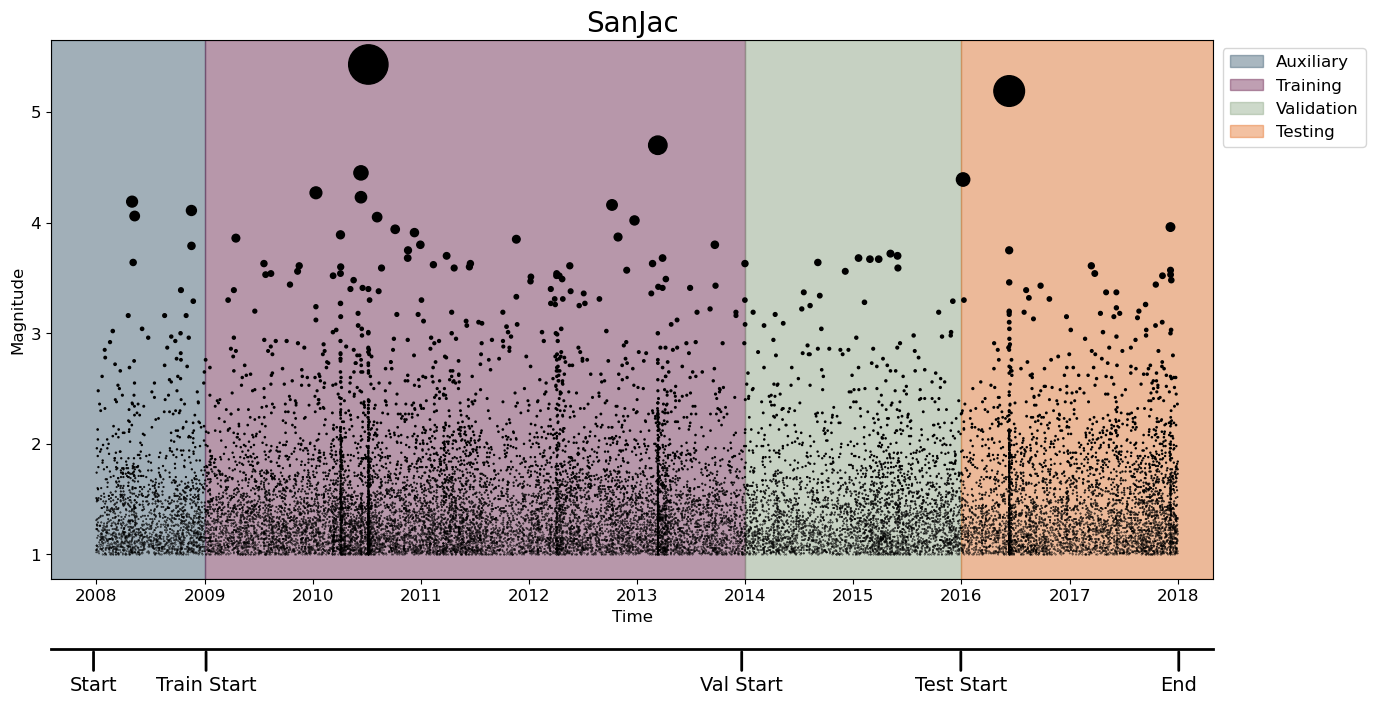

In [13]:
# time windows for training, validation, and testing
auxiliary_start = pd.Timestamp('2008-01-01 00:00:00')
training_start = pd.Timestamp('2009-01-01 00:00:00')
validation_start = pd.Timestamp('2014-01-01 00:00:00')
testing_start = pd.Timestamp('2016-01-01 00:00:00')
testing_end = pd.Timestamp('2018-01-01 00:00:00')

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor((0.95, 0.95, 0.95))

# Plotting earthquakes
z = (8**SanJac_catalog['magnitude'])*0.01
scatter = ax.scatter(SanJac_catalog['time'], SanJac_catalog['magnitude'], s=z, color='black')

xmin, xmax = pd.Timestamp('2007-08-01'), pd.Timestamp('2018-05-01')
ax.set_xlim(xmin, xmax)

# Highlighting time windows
alph = 0.4
ax.axvspan(xmin, training_start, color=colors[6], alpha=alph, label='Auxiliary', zorder=-100)
ax.axvspan(training_start, validation_start, color=colors[0], alpha=alph, label='Training', zorder=-100)
ax.axvspan(validation_start, testing_start, color=colors[2], alpha=alph, label='Validation', zorder=-100)
ax.axvspan(testing_start, xmax, color=colors[3], alpha=alph, label='Testing', zorder=-100)

trans = ax.get_xaxis_transform()
lineheight, textheight = -.13, -.18

# Annotations for train/val/test windows
annotations = [
    ('Start', 13870),
    ('Train Start', 14250),
    ('Val Start', 16059),
    ('Test Start', 16799),
    ('End', 17535),
]

for label, x_pos in annotations:
    ax.annotate(
        label, xy=(x_pos, lineheight), xycoords=trans, ha="center", va="top", fontsize=14,
        xytext=(x_pos, textheight), textcoords=trans, arrowprops=dict(arrowstyle='-', color='black', lw=2)
    )

ax.plot([xmin, xmax], [lineheight, lineheight], color="k", transform=trans, clip_on=False, lw=2)

# Labels and formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.001, 1), fontsize=12)
ax.set_title('SanJac',fontsize=20)

plt.show()

### SaltonSea

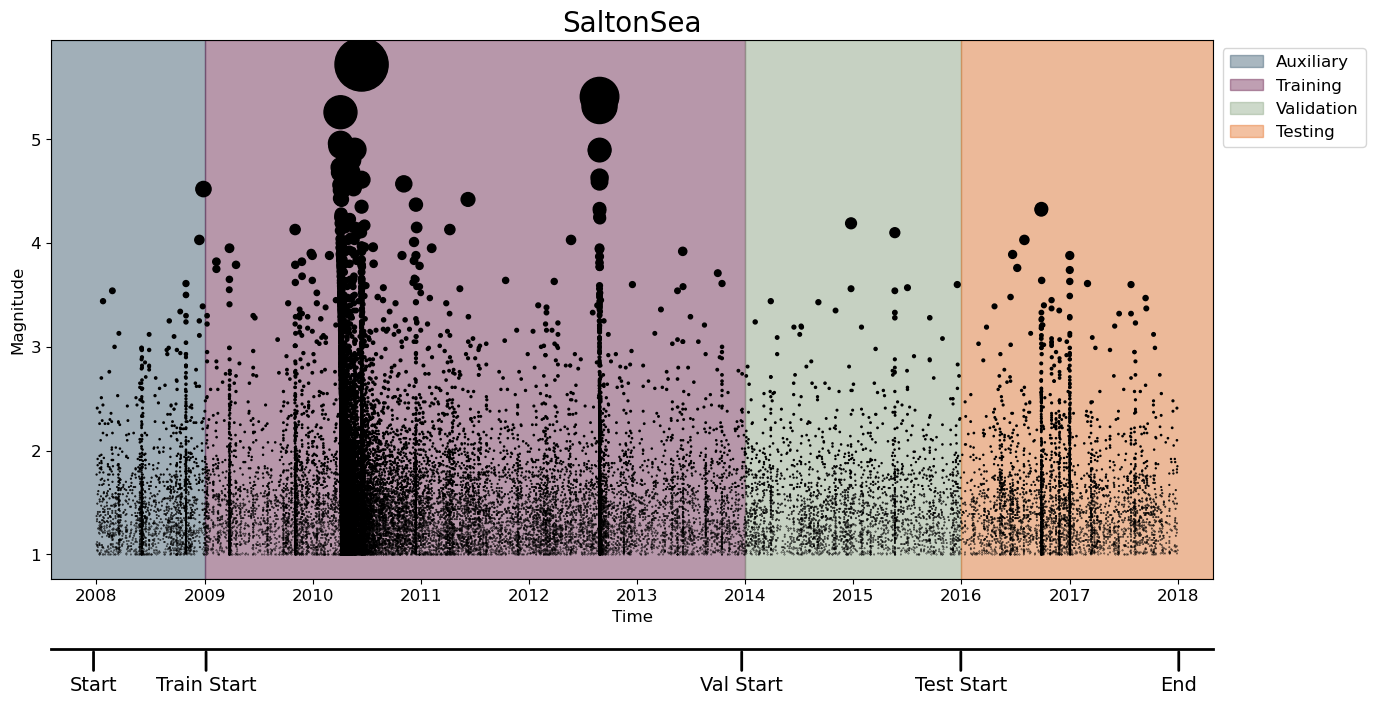

In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor((0.95, 0.95, 0.95))

# Plotting earthquakes
z = (8**SaltonSea_catalog['magnitude'])*0.01
scatter = ax.scatter(SaltonSea_catalog['time'], SaltonSea_catalog['magnitude'], s=z, color='black')

ax.set_xlim(xmin, xmax)

# Highlighting time windows
ax.axvspan(xmin, training_start, color=colors[6], alpha=alph, label='Auxiliary', zorder=-100)
ax.axvspan(training_start, validation_start, color=colors[0], alpha=alph, label='Training', zorder=-100)
ax.axvspan(validation_start, testing_start, color=colors[2], alpha=alph, label='Validation', zorder=-100)
ax.axvspan(testing_start, xmax, color=colors[3], alpha=alph, label='Testing', zorder=-100)

trans = ax.get_xaxis_transform()

for label, x_pos in annotations:
    ax.annotate(
        label, xy=(x_pos, lineheight), xycoords=trans, ha="center", va="top", fontsize=14,
        xytext=(x_pos, textheight), textcoords=trans, arrowprops=dict(arrowstyle='-', color='black', lw=2)
    )

ax.plot([xmin, xmax], [lineheight, lineheight], color="k", transform=trans, clip_on=False, lw=2)

# Labels and formatting
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.001, 1), fontsize=12)
ax.set_title('SaltonSea',fontsize=20)

plt.show()

Finally, since ETAS uses the great-circle distance between two points on a sphere (km), for the NPPs we need to project the coordinates of the events into a space such that inter-event distances are in km. To do this, we can use the Azimuthal equidistant projection [5], which preserves distances from all points to a center point.

We pass the mean coordinates of the catalog as the center coordinates of the projection.

In [15]:
SanJac_center_latitude = SanJac_catalog['latitude'].mean()  # Latitude of the center point
SanJac_center_longitude = SanJac_catalog['longitude'].mean()  # Longitude of the center point

SaltonSea_center_latitude = SaltonSea_catalog['latitude'].mean()  # Latitude of the center point
SaltonSea_center_longitude = SaltonSea_catalog['longitude'].mean()  # Longitude of the center point

# Convert latitude and longitude to Cartesian coordinates using Plate Carrée projection
SaltonSea_catalog['x'], SaltonSea_catalog['y'] = azimuthal_equidistant_projection(SaltonSea_catalog['latitude'], SaltonSea_catalog['longitude'], SaltonSea_center_latitude, SaltonSea_center_longitude)
SanJac_catalog['x'], SanJac_catalog['y'] = azimuthal_equidistant_projection(SanJac_catalog['latitude'], SanJac_catalog['longitude'], SanJac_center_latitude, SanJac_center_longitude)

Finally, we can write these pre-processed catalogs to file.

In [16]:
SanJac_catalog.to_csv("SanJac_catalog.csv", index=False)
SaltonSea_catalog.to_csv("SaltonSea_catalog.csv", index=False)

## References

[1]: Ross, Z. E., Trugman, D. T., Hauksson, E., & Shearer, P. M. (2019). Searching for hidden earthquakes in Southern California. Science, 364(6442), 767-771.

[2]: Wiemer, S., & Wyss, M. (2000). Minimum magnitude of completeness in earthquake catalogs: Examples from Alaska, the western United States, and Japan. Bulletin of the Seismological Society of America, 90(4), 859-869.

[3]: Dascher-Cousineau, K., Shchur, O., Brodsky, E. E., & Günnemann, S. (2023). Using deep learning for flexible and scalable earthquake forecasting. Geophysical Research Letters, 50, e2023GL103909. https://doi.org/10.1029/2023GL103909

[4]: Hill, R. G., Weingarten, M., Rockwell, T. K., & Fialko, Y. (2023). Major southern San Andreas earthquakes modulated by lake-filling events. Nature, 618(7966), 761-766.

[5]: Bradley, A. D. (1945). Azimuthal Equidistant Projection of the Sphere. The American Mathematical Monthly, 52(3), 148-151.